In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import TextVectorization


In [4]:
print(tf.__version__)

2.7.0


# Download IMDB dataset

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 20s 0us/step


In [6]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [7]:
os.listdir(dataset_dir)

['test', 'train', 'README', 'imdbEr.txt', 'imdb.vocab']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'unsup',
 'labeledBow.feat',
 'neg',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos']

In [9]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# load the dataset

In [11]:
# remove unsed folder
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [51]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [52]:
raw_train_ds




<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [53]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [54]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [55]:
# now validation set

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [56]:
# now test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# preprocessing

In [57]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [58]:
print (re.escape(string.punctuation))
print ('[%s]' % re.escape(string.punctuation))

!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~
[!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~]


In [59]:
test_out_str = custom_standardization("Hello! World?")
print (test_out_str)

tf.Tensor(b'hello world', shape=(), dtype=string)


In [60]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

raw_train_ds is in a form of tf.data.Dataset

> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3]) \
> dataset = dataset.map(lambda x: x*2) \
> list(dataset.as_numpy_iterator()) \
> [2, 4, 6]

In [61]:
# Make a text-only dataset (without labels), then call adapt
# If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted,
# it will analyze the dataset, determine the frequency of individual string values,
# and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped,
# depending on the configuration options for this layer; if there are more unique values
# in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [62]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [63]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [64]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [66]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# model 

In [68]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (G  (None, 16)                0         
lobalAveragePooling1D)                                           
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
_________________________________________________________________
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [69]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


In [70]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 0.6652 - binary_accuracy: 0.6909 - val_loss: 0.6162 - val_binary_accuracy: 0.7742
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5491 - binary_accuracy: 0.8009 - val_loss: 0.4988 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4457 - binary_accuracy: 0.8453 - val_loss: 0.4207 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3796 - binary_accuracy: 0.8648 - val_loss: 0.3743 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3361 - binary_accuracy: 0.8794 - val_loss: 0.3456 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3049 - binary_accuracy: 0.8880 - val_loss: 0.3266 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 4s 6ms/ste

In [71]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3105 - binary_accuracy: 0.8734
Loss:  0.31049731373786926
Accuracy:  0.8734400272369385


In [72]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

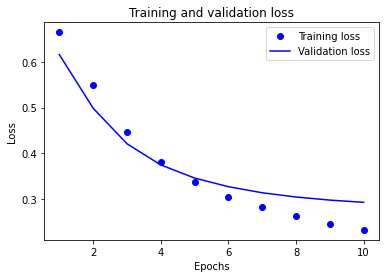

In [73]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

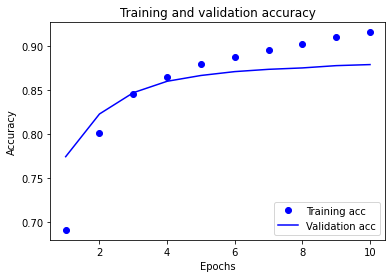

In [74]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [75]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - accuracy: 0.8734
0.8734400272369385


In [76]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6166784 ],
       [0.43855026],
       [0.35397995]], dtype=float32)

# stackoverflow!!!